In [1]:
import os
import pandas as pd
import numpy as np
import pywt
import itertools
import networkx as nx
import matplotlib.pyplot as plt


folder_path = 'C:\\Users\\19606\\Desktop\\GMDandGIC\\GICdata\\event_20131002\\GIC\\'

time_column = 'SampleDateTime'
gic_column = 'GICMeasured'

file_names = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

In [2]:
def determine_max_level(data_length, wavelet='db4'):
    return pywt.swt_max_level(data_length)


def modwt(data, wavelet, level):
    return pywt.swt(data, wavelet, level=level, start_level=0)

# This function calculates the cross-correlation between two sets of wavelet coefficients.
# The wavelet coefficient is calculated by MODWT and represents the components of the original signal on different frequency scales. 
# Here, wt1 and wt2 represent the wavelet coefficients of the two signals on the same scale
# and the function calculates and returns the correlation coefficients of these coefficients on each scale.
def wavelet_cross_correlation(wt1, wt2):
    corrs = []
    for coeff1, coeff2 in zip(wt1, wt2):
        corr = np.corrcoef(coeff1[0], coeff2[0])[0, 1]
        corrs.append(corr)
    return corrs

# This function calculates the cross-correlation of two time series in the sliding window. 
# This is often used to study how the correlation of time series changes at different points in time
def sliding_window_cross_correlation(wt1, wt2, window_size=30):

    assert len(wt1) == len(wt2)
    sliding_corrs = []
    
    for start in range(len(wt1) - window_size + 1):
        end = start + window_size
        window_corr = np.corrcoef(wt1[start:end], wt2[start:end])[0, 1]
        sliding_corrs.append(window_corr)
    
    return sliding_corrs
# The first function is to obtain a one-time correlation on different scales of the wavelet transform, 
# while the second function is to obtain a continuous correlation of the time varying window
def make_length_even(data):
    return data if len(data) % 2 == 0 else np.append(data, data[-1])
edges = []

In [3]:
modwt_results = {}


for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.drop_duplicates(subset=time_column).set_index(time_column)
    df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='T'), method='nearest')
    resampled_df = df.resample('T').mean().interpolate(method='spline', order=3)
    gic_signal = make_length_even(resampled_df[gic_column].values)
    level = determine_max_level(len(gic_signal))
    modwt_result = modwt(gic_signal, 'db4', level)
    modwt_results[file_name] = modwt_result

In [4]:
print(modwt_results)

{'2013E02_10056.csv': [(array([1.71528357, 1.63627665, 1.49843081, ..., 1.54107532, 1.52978502,
       1.61506904]), array([ 0.01099079, -0.11197576,  0.10628366, ..., -0.04284867,
       -0.07861733,  0.13332257]))], '2013E02_10075.csv': [(array([-3.01563872, -1.62265178,  0.45297635, ..., -2.97403737,
       -1.71927223, -2.05354877]), array([ 0.17460861, -0.93217187, -0.1414064 , ...,  1.76989585,
       -0.4176934 , -0.36671653]))], '2013E02_10077.csv': [(array([-0.72924141, -0.809588  , -0.9006967 , ..., -0.75243032,
       -0.75633372, -0.73224205]), array([-0.00502364, -0.0001406 , -0.00460478, ..., -0.06298094,
        0.02133734,  0.02013054]))], '2013E02_10083.csv': [(array([-12.60782975, -12.50861742, -12.41943926, ..., -12.58283994,
       -12.57898828, -12.6086264 ]), array([ 0.01005597,  0.00963081,  0.00694375, ...,  0.07958165,
       -0.03188831, -0.03145638]))], '2013E02_10094.csv': [(array([-0.01576105, -0.00945224, -0.00230378, ..., -0.01391928,
       -0.01361087, 

In [5]:

desired_length = 1622  

filtered_modwt_results = {file: modwt_vals for file, modwt_vals in modwt_results.items() if len(modwt_vals[0][0]) == desired_length}

filtered_modwt_results

{'2013E02_10056.csv': [(array([1.71528357, 1.63627665, 1.49843081, ..., 1.54107532, 1.52978502,
          1.61506904]),
   array([ 0.01099079, -0.11197576,  0.10628366, ..., -0.04284867,
          -0.07861733,  0.13332257]))],
 '2013E02_10075.csv': [(array([-3.01563872, -1.62265178,  0.45297635, ..., -2.97403737,
          -1.71927223, -2.05354877]),
   array([ 0.17460861, -0.93217187, -0.1414064 , ...,  1.76989585,
          -0.4176934 , -0.36671653]))],
 '2013E02_10077.csv': [(array([-0.72924141, -0.809588  , -0.9006967 , ..., -0.75243032,
          -0.75633372, -0.73224205]),
   array([-0.00502364, -0.0001406 , -0.00460478, ..., -0.06298094,
           0.02133734,  0.02013054]))],
 '2013E02_10083.csv': [(array([-12.60782975, -12.50861742, -12.41943926, ..., -12.58283994,
          -12.57898828, -12.6086264 ]),
   array([ 0.01005597,  0.00963081,  0.00694375, ...,  0.07958165,
          -0.03188831, -0.03145638]))],
 '2013E02_10112.csv': [(array([-0.28284271, -0.28284271, -0.28284271

In [6]:
edges = []
for (file1, wt1), (file2, wt2) in itertools.combinations(filtered_modwt_results.items(), 2):
    cross_corrs = wavelet_cross_correlation(wt1, wt2)
    print(cross_corrs)
    threshold = 0.5
    for corr in cross_corrs:
        if np.abs(corr) > threshold:
            edges.append((file1, file2, corr))

[-0.0806450920787977]
[-0.011479999812570307]
[-0.008959483445292472]
[0.004247951252249997]
[0.019704824959325344]
[0.021654845607935055]
[-0.039601742921464525]
[-0.007832655395284256]
[0.11056720804579986]
[-0.09741720286750677]
[-0.21451846897645788]
[-0.26597334454546556]
[-0.1821993032185051]
[-0.27149095363804127]
[-0.001401623537184207]
[-0.09922379867331207]
[-0.18954334196800668]
[-0.344473930609223]
[0.02257428172873056]
[-0.018409051466800185]
[0.02884694770929903]
[-0.1906230718046148]
[0.027557824909139644]
[-0.2330503929090214]
[-0.02530733942073684]
[nan]
[0.1811637744269706]
[-0.16958123157951221]
[-0.25810947844851756]
[0.3144977139730723]
[-0.037408327746456346]
[0.1435942756166668]
[0.19554946020060637]
[-0.037867713818994626]
[-0.10447734585599232]
[0.21805609789553754]
[0.23110899946825916]
[0.03835968528513892]
[0.08955734853748272]
[0.07863026399309218]
[0.21010822044218505]
[-0.12580632864745028]
[0.3145744075819303]
[-0.11347254497861213]
[0.07972282437272608]

c:\Users\19606\anaconda3\envs\py37\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\19606\anaconda3\envs\py37\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[-0.06815425442475238]
[0.06521729490387398]
[0.07395439350607044]
[0.07429231543897273]
[-0.31786276244129963]
[0.16198892180015068]
[0.03193828203337442]
[0.09550463907550595]
[-0.017624271468195684]
[0.30480219671112235]
[-0.06016318019706311]
[0.09443513430925926]
[-0.1983710740745281]
[-0.7106541605068531]
[0.12347070482947199]
[0.44838513129090823]
[-0.4739122746016501]
[-0.32071976072020353]
[-0.09266493020990874]
[-0.08752884951584368]
[0.016873513636070533]
[0.059324012968161734]
[-0.18945217173138934]
[-0.2739825397401906]
[-0.17099458507996662]
[-0.16347191714997186]
[0.18835250773169343]
[-0.2604879120383692]
[-0.03255262549564111]
[0.2370852245870235]
[0.061933970892596744]
[0.14696452183864675]
[0.06657897140632116]
[-0.055490511279099604]
[-0.017354535597948473]
[0.04899659882434005]
[-0.033643831552074614]
[-0.005732192929333071]
[nan]
[nan]
[-0.23083295523483321]
[0.057801432444854514]
[-0.2312610688292218]
[0.04163133558888922]
[-0.4391615337682181]
[0.032740404747877

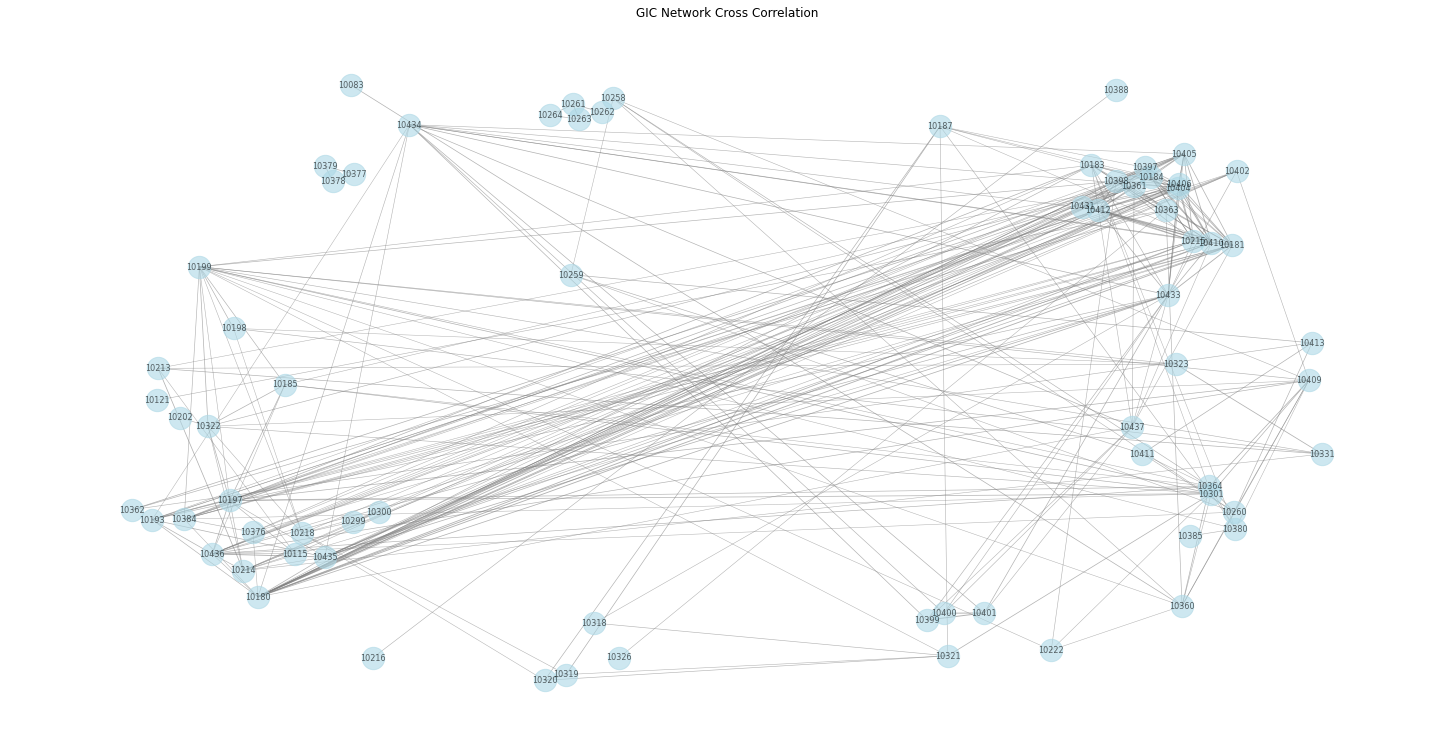

In [15]:
G = nx.Graph()

processed_edges = []
for edge in edges:
    node1, node2, weight = edge
    node1_label = node1.replace('2013E02_', '').replace('.csv', '')
    node2_label = node2.replace('2013E02_', '').replace('.csv', '')
    processed_edges.append((node1_label, node2_label, weight))

G.add_weighted_edges_from(processed_edges)

plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G)  # Positions for all nodes

weights = [G[u][v]['weight'] for u, v in G.edges()]

nx.draw(G, pos, width=weights, with_labels=True, node_color='lightblue', 
        edge_color='gray', node_size=500, alpha=0.6, font_size=8)

plt.title('GIC Network Cross Correlation')
plt.show()
# This diagram shows a network diagram where the nodes represent different monitors.
# Lines between nodes show correlations between different data sets. 
# The more nodes are wired, the higher the correlation with the other data sets.

In [8]:
sliding_correlations = {}
for (file1, wt1), (file2, wt2) in itertools.combinations(filtered_modwt_results.items(), 2):
    corrs_over_time = sliding_window_cross_correlation(wt1[0][0], wt2[0][0])
    sliding_correlations[(file1, file2)] = corrs_over_time

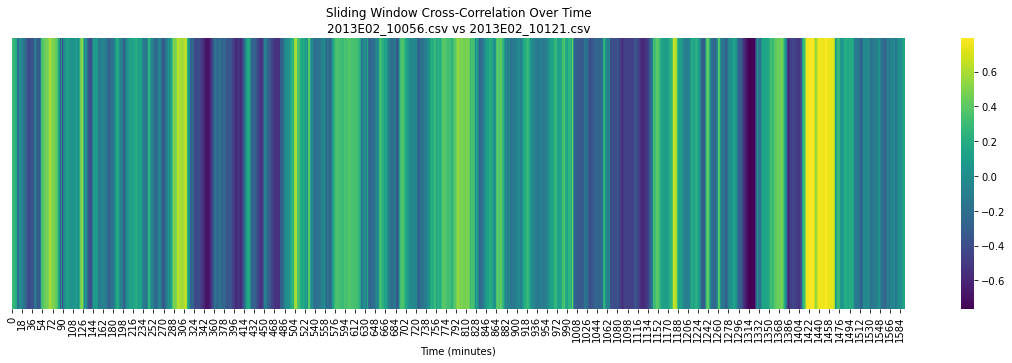

In [18]:
import seaborn as sns
file_pair_to_visualize = (file_names[0], file_names[9])


correlations_over_time = sliding_correlations[file_pair_to_visualize]


time_axis = range(len(correlations_over_time))


plt.figure(figsize=(20, 5))  
sns.heatmap([correlations_over_time], cmap="viridis", yticklabels=False)
plt.title(f"Sliding Window Cross-Correlation Over Time\n{file_pair_to_visualize[0]} vs {file_pair_to_visualize[1]}")
plt.xlabel("Time (minutes)")
plt.show()